In [219]:
import pandas as pd
import numpy as np
from datetime import date

In [220]:
# constants
FILE_PATH = "cars.csv"

## Data

This dataset was retrieved from [kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/us-sales-cars-dataset). It provides comprehensive information about used cars available for sale in the United States. The dataset contains the following key attributes:

- **Brand:** The brand or manufacturer of the car.
- **Model:** The specific model of the car.
- **Mileage:** The number of miles the car has been driven.
- **Year:** The manufacturing year of the car.
- **Status:** Indicates whether the car is new, used, or certified pre-owned.
- **Dealer:** Information about the dealer or seller offering the car.
- **Price:** The listed price of the car in USD.

In [221]:
df = pd.read_csv(FILE_PATH, encoding="utf-16")
df.head()

,Brand,Model,Year,Status,Mileage,Dealer,Price
0,Mazda,CX-5,2023,New,NaN,NaN,36703.0
1,Kia,Sportage,2023,New,NaN,Classic Kia,28990.0
2,Chevrolet,Camaro,2024,New,NaN,Classic Chevrolet Beaumont,41425.0
3,Ford,Bronco,2023,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0
4,Acura,TLX,2021,Used,30384.0,Mike Smith Nissan,34499.0


## Preprocessing the Data

To clean the data we will:
1. data cleaning
2. data transformation
3. feature reduction 

In [222]:
row_count = len(df)
print(f"Total Rows: {len(df)}")
df.isnull().sum().map(lambda sum: f"{sum / row_count:.2%}")

Total Rows: 51793


Brand       0.00%
Model       0.00%
Year        0.00%
Status      0.00%
Mileage    55.63%
Dealer      0.20%
Price       2.22%
dtype: object

### Missing Values
The statistics above indicate the percentage of missing data under each column. Many of the rows are missing entries for mileage. We can drop the rows with missing values for mileage and price.

In [223]:
print(f"Rows with missing mileage: {df.Mileage.count()}")
print(f"Rows with new status and missing mileage: {df[(df.Status == 'New') & (df.Mileage.isna())].Status.count()}")

Rows with missing mileage: 22981
Rows with new status and missing mileage: 28811


Replace the mileage to 0 of rows with new status and missing mileage then drop the rest NAs.


In [224]:
df.loc[(df['Status'] == 'New') & (df['Mileage'].isna()), 'Mileage'] = 0
df = df.dropna()
print(f"Total Rows: {len(df)}")

Total Rows: 50540


### Remove duplicates

In [225]:
df = df.drop_duplicates()
print(f"Total Rows: {len(df)}")

Total Rows: 49536


### Data Transformation / Normalization
- we should scale certain features (like year to age)
- we should check for any typos or inconsistencies in text

In [226]:
df["Age"] = 2024 - df.Year

In [227]:
for brand in df.Brand.unique():
    print(brand, end=",\t")

Kia,	Chevrolet,	Ford,	Acura,	Volkswagen,	GMC,	BMW,	Hyundai,	Jeep,	Dodge,	Infiniti,	Honda,	Lexus,	Toyota,	Cadillac,	Buick,	Mazda,	Lincoln,	Mercury,	MINI,	RAM,	Land Rover,	Audi,	Nissan,	Mercedes,	Porsche,	Subaru,	Jaguar,	Maserati,	Alfa Romeo,	Tesla,	Bentley,	Genesis,	Volvo,	Chrysler,	Mitsubishi,	FIAT,	Rivian,	Aston Martin,	Lamborghini,	Hummer,	Saturn,	Rolls-Royce,	Ferrari,	Polestar,	Lucid,	Scion,	Pontiac,	Karma,	Smart,	McLaren,	Lotus,	Saab,	Maybach,	Suzuki,	International Scout,	Geo,	Oldsmobile,	Isuzu,	

In [228]:
for brand in df.Model.unique():
    print(brand, end=",\t")
    

Sportage,	Camaro,	Bronco,	TLX,	Golf,	Yukon,	M340,	Sonata,	Grand Cherokee,	Wagoneer,	Durango,	Mustang,	F-350,	QX30,	Passport,	ES,	Sierra,	Tundra,	CT5,	Envista,	CX-5,	Civic,	Accord,	Atlas,	4Runner,	Sequoia,	Continental,	Marquis,	IS,	LX,	RZ 450e,	Escalade,	LS,	Nautilus,	Integra,	MDX,	435 i,	ILX,	Palisade,	X7,	Escape,	Cooper,	iX M60,	X3,	Canyon,	Land Cruiser,	LYRIQ,	Trax,	1500,	Navigator,	Range Rover,	RS 5,	Leaf S,	Altima,	E-Class,	GLS 600,	Highlander,	GLS 450,	Cayenne,	Q7,	TT,	Wrangler,	GT,	F-150,	F-250,	Defender,	QX80,	QX60,	Essentia,	GLE,	Panamera,	M3,	Telluride,	Forte,	A7,	X5,	330 i,	iX xDrive50,	740,	Juke,	CT6,	Mazda3,	WRX,	Crosstrek,	Ranger,	Explorer,	Town Car,	Fusion,	2500,	Gladiator,	Q5,	F-PACE,	Discovery,	Silverado,	GLA,	G 550,	e-tron,	S-Class,	Ghibli,	Tahoe,	6,	CR-V,	Elantra,	GX,	Odyssey,	Giulia,	Corvette,	C-Class,	CX-9,	CL,	X4,	3,	Suburban,	Fiesta,	Tacoma,	Model X,	Flying Spur,	Roadster,	Corsair,	MX-5 Miata,	xD,	Tucson,	RX,	LC,	Macan,	Taycan,	RDX,	Outback,	GV80,	G70,	Challenger,

In [229]:
df.describe()

,Year,Mileage,Price,Age
count,49536.000000,49536.000000,4.953600e+04,49536.000000
mean,2020.866481,24753.097121,5.126538e+04,3.133519
std,4.275406,40373.370957,3.580619e+04,4.275406
min,1959.000000,0.000000,1.990000e+03,0.000000
25%,2020.000000,0.000000,3.079900e+04,1.000000
50%,2023.000000,0.000000,4.548000e+04,1.000000
75%,2023.000000,38564.500000,6.310500e+04,4.000000
max,2024.000000,400396.000000,1.299995e+06,65.000000


### Breakdown by Car Manufacturer

Our goal is to provide an indepth analysis of the dataset per car manufacturer, and extract features well suited for predicting prices

In [230]:
# Print the counts for each brand
brand_counts = df['Brand'].value_counts()
for brand, count in brand_counts.items():
    print(f"{brand}: {count} rows")

Ford: 6255 rows
Chevrolet: 4893 rows
Toyota: 4598 rows
Jeep: 3100 rows
GMC: 2517 rows
BMW: 2403 rows
Mercedes: 2017 rows
Honda: 1969 rows
Lexus: 1769 rows
RAM: 1719 rows
Kia: 1671 rows
Audi: 1478 rows
Nissan: 1424 rows
Dodge: 1167 rows
Mazda: 1139 rows
Cadillac: 1130 rows
Hyundai: 1107 rows
Volkswagen: 1018 rows
Land Rover: 839 rows
Subaru: 822 rows
Acura: 786 rows
Porsche: 683 rows
Volvo: 682 rows
Lincoln: 579 rows
Genesis: 568 rows
Infiniti: 543 rows
Buick: 444 rows
Tesla: 351 rows
Chrysler: 334 rows
Mitsubishi: 273 rows
Jaguar: 267 rows
Alfa Romeo: 166 rows
Maserati: 148 rows
MINI: 127 rows
Bentley: 102 rows
Aston Martin: 71 rows
Rolls-Royce: 61 rows
Ferrari: 47 rows
Pontiac: 40 rows
Lamborghini: 37 rows
McLaren: 37 rows
FIAT: 28 rows
Polestar: 24 rows
Scion: 24 rows
Hummer: 19 rows
Saturn: 15 rows
Rivian: 10 rows
Mercury: 7 rows
Saab: 6 rows
Lucid: 4 rows
Karma: 4 rows
Smart: 3 rows
Lotus: 3 rows
Suzuki: 3 rows
Maybach: 1 rows
International Scout: 1 rows
Geo: 1 rows
Oldsmobile: 1 r

In [231]:
brand_counts = df['Brand'].value_counts()
brands_to_remove = brand_counts[brand_counts < 550].index
mask = df['Brand'].isin(brands_to_remove)

# Create a new DataFrame without rows for brands with less than 200 rows
df_with_features = df[~mask]
df_with_features

,Brand,Model,Year,Status,Mileage,Dealer,Price,Age
1,Kia,Sportage,2023,New,0.0,Classic Kia,28990.0,1
2,Chevrolet,Camaro,2024,New,0.0,Classic Chevrolet Beaumont,41425.0,0
3,Ford,Bronco,2023,Used,1551.0,Mike Smith Chrysler Dodge Jeep RAM,58900.0,1
4,Acura,TLX,2021,Used,30384.0,Mike Smith Nissan,34499.0,3
5,Volkswagen,Golf,2022,Certified,13895.0,Volkswagen of Beaumont,34000.0,2
...,...,...,...,...,...,...,...,...
51787,Mercedes,GLB,2023,New,0.0,Mercedes-Benz of El Dorado Hills,50635.0,1
51788,Chevrolet,Corvette,2023,New,0.0,Chase Chevrolet,122455.0,1
51789,Chevrolet,Corvette,2023,New,0.0,Chase Chevrolet,125930.0,1
51790,Jeep,Wrangler,2023,New,0.0,Stockton Dodge Chrysler Jeep RAM,53715.0,1


### New Feature ideas

In [232]:
## dataframe per manufacture
grouped_by_brand = df_with_features.groupby('Brand')
brand_datasets = {brand: group for brand, group in grouped_by_brand if len(group) > 550}

In [233]:
#create new binary feature that signifies the suppossed purpose of car (beater, daily, luxury, sport)
#will be manually assigned per make/model pair

In [234]:
#simplify dealer feature to be only the name of the car brand rather than the full name
# or use the dealer names to extract the state it was sold in (Cal, Il, Ohio, etc)

In [235]:
#average mileage per year
for brand, df in brand_datasets.items():
    df['Yearly_Miles'] = df['Mileage'] / (2023 - df['Year'])
brand_datasets['Volvo']

,Brand,Model,Year,Status,Mileage,Dealer,Price,Age,Yearly_Miles
496,Volvo,XC90,2024,New,0.0,All Star Volvo Cars,69065.0,0,-0.000000e+00
622,Volvo,S90,2024,New,0.0,Volvo Cars of Austin,78395.0,0,-0.000000e+00
739,Volvo,XC60,2023,New,0.0,Bergeron Volvo,59340.0,1,NaN
1128,Volvo,XC90,2020,Used,27730.0,Autos of Dallas,37480.0,4,9.243333e+03
1139,Volvo,XC60,2021,Used,24136.0,Autos of Dallas,35880.0,3,1.206800e+04
...,...,...,...,...,...,...,...,...,...
51518,Volvo,XC40,2022,Used,24556.0,Boch Honda West,37570.0,2,2.455600e+04
51570,Volvo,XC40,2021,Certified,34566.0,Lovering Volvo Cars Nashua,35815.0,3,1.728300e+04
51571,Volvo,XC90,2023,New,0.0,Lovering Volvo Cars Nashua,61660.0,1,NaN
51725,Volvo,XC90,2023,Certified,19563.0,Lovering Volvo Cars Meredith,66985.0,1,inf


## Plots

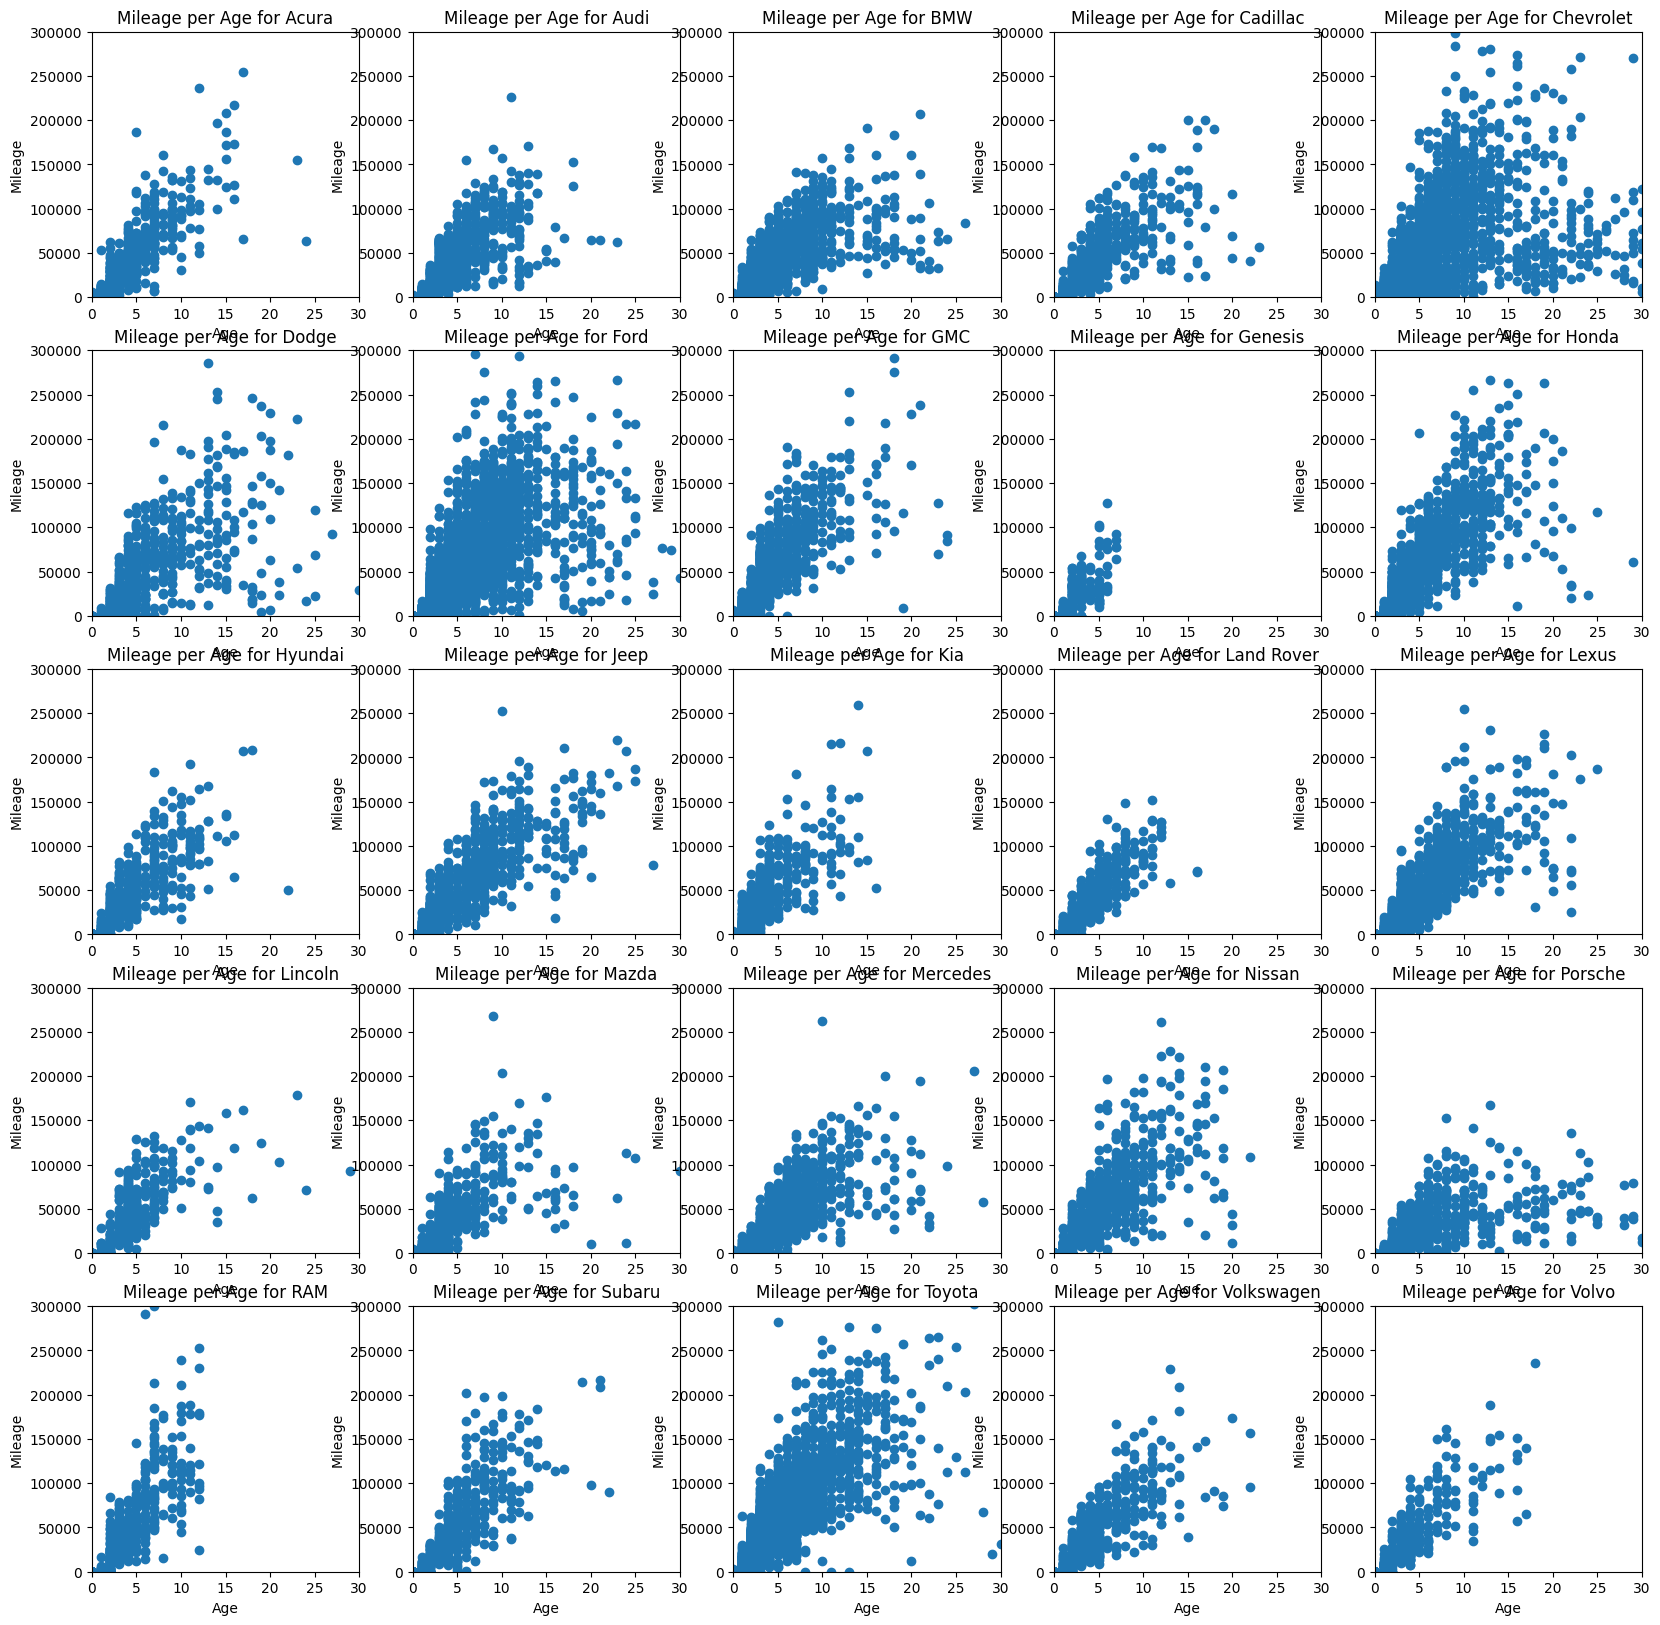

In [236]:
#milage per age 
    #to showcase reliability
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
c = 0
for brand, brand_df in brand_datasets.items():

    x = str(brand)
    axs[c].scatter(brand_df['Age'], brand_df['Mileage'], label=brand)

    axs[c].set_xlabel('Age')
    axs[c].set_ylabel('Mileage')
    axs[c].set_title(f'Mileage per Age for {brand}')

    axs[c].set_xlim(0, 30)
    axs[c].set_ylim(0, 300000)

    c+=1


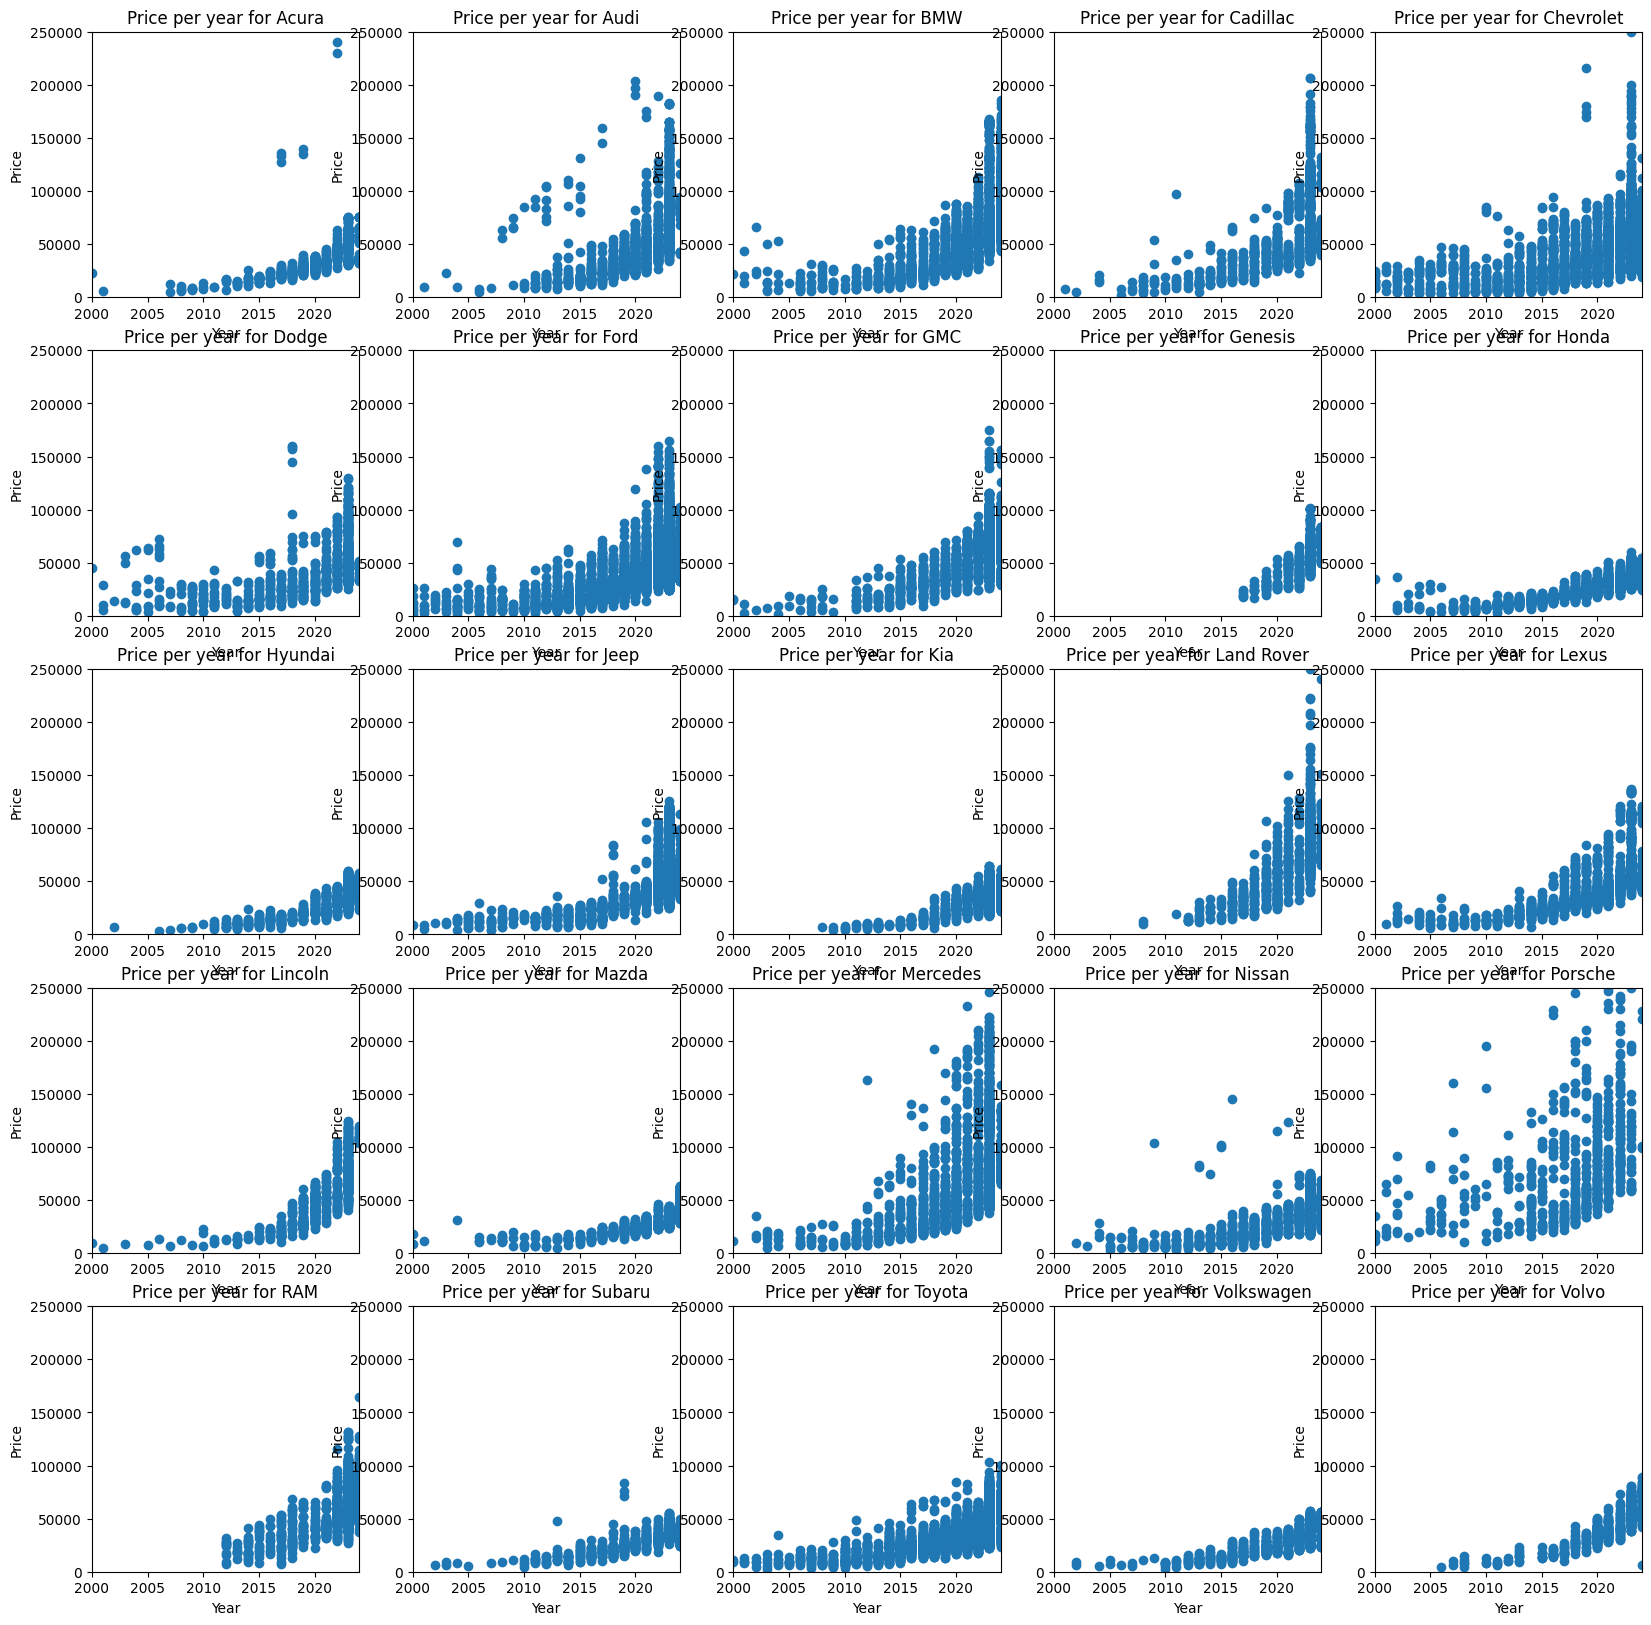

In [237]:
#price per year
    #showcase price trends per brand

import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(20, 20))
axs = axs.flatten()
c = 0
for brand, brand_df in brand_datasets.items():

    x = str(brand)
    axs[c].scatter(brand_df['Year'], brand_df['Price'], label=brand)

    axs[c].set_xlabel('Year')
    axs[c].set_ylabel('Price')
    axs[c].set_title(f'Price per year for {brand}')

    axs[c].set_xlim(2000, 2024)
    axs[c].set_ylim(0, 250000)

    c+=1